In [1]:
import cv2
import numpy as np
import pickle
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
import re

from color_gradient_thresholds import abs_sobel_thresh, mag_thresh, dir_threshold, hls_select, rgb_select, ycrcb_select

%matplotlib inline

In [2]:
class Lane_Detector:
    def __init__(self):
        """
        Provides methods for lane line detection and visualiztion
        """
        dist_pickle = pickle.load(open("camera_cal/calibration_pickle.p", "rb"))
        self.camera_mtx = dist_pickle["mtx"]
        self.camera_dist = dist_pickle["dist"]
        
        self.lane_shape_src = []
        self.lane_shape_dst = []
        self.laneShapeSet = False
        
        
        #Denotes whether lane lines were detected in the previous frame
        self.detected = False

        #Counts number of frames in a row that lane lines have failed to be detected
        self.consecutive_misses = 0
        
        self.fit_weights = [.6, .25, .15]
        
        self.left_fits = []
        
        self.right_fits = []
        
        
        self.averaged_left_fit = []
        self.averaged_right_fit = []
        
        self.high_conf_count = 0
        
        self.lane_data = {}
        
        # Dictionary to save images of each step in the image processing pipeline
        self.visualizations = {}
        
        self.visualized_windows = False
        self.visualized_roi = False
    
    def update_averaged_left_fit(self, left_fit):
        """
        Updates the average polynomial fit for the left side of the lane
        """
        self.left_fits.append(left_fit)
        
        if self.high_conf_count < 3:
            self.averaged_left_fit = left_fit
        else:
        
            length = len(self.left_fits)
            a1 = self.left_fits[length-1][0]
            b1 = self.left_fits[length-1][1]
            c1 = self.left_fits[length-1][2]

            a2 = self.left_fits[length-2][0]
            b2 = self.left_fits[length-2][1]
            c2 = self.left_fits[length-2][2]

            a3 = self.left_fits[length-3][0]
            b3 = self.left_fits[length-3][1]
            c3 = self.left_fits[length-3][2]

            A = np.average([a1, a2, a3], weights=self.fit_weights)
            B = np.average([b1, b2, b3], weights=self.fit_weights)
            C = np.average([c1, c2, c3], weights=self.fit_weights)

            self.averaged_left_fit = [A,B,C]
        

        
    def update_averaged_right_fit(self, right_fit):
        """
        Updates the average polynomial fit for the right side of the lane
        """
        self.right_fits.append(right_fit)
        
        if self.high_conf_count < 3:
            self.averaged_right_fit = right_fit
        else:
            
            length = len(self.right_fits)
            
            a1 = self.right_fits[length-1][0]
            b1 = self.right_fits[length-1][1]
            c1 = self.right_fits[length-1][2]

            a2 = self.right_fits[length-2][0]
            b2 = self.right_fits[length-2][1]
            c2 = self.right_fits[length-2][2]

            a3 = self.right_fits[length-3][0]
            b3 = self.right_fits[length-3][1]
            c3 = self.right_fits[length-3][2]

            A = np.average([a1, a2, a3], weights=self.fit_weights)
            B = np.average([b1, b2, b3], weights=self.fit_weights)
            C = np.average([c1, c2, c3], weights=self.fit_weights)

            self.averaged_right_fit = [A,B,C]
            
    def new_fit(self, binary):
        """
        Search for left and right lane line pixels using a sliding window technique
        """
        # Choose the number of sliding windows
        nwindows = 9
        # Set the width of the windows +/- margin
        margin = 100
        # Set minimum number of pixels found to recenter window
        minpix = 50  
        # Set height of windows
        window_height = np.int(binary.shape[0]/nwindows)

        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((binary, binary, binary))*255

        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Take a histogram of the bottom half of the image
        histogram = np.sum(binary[binary.shape[0]//2:,:], axis=0)

        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base

        
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary.shape[0] - (window+1)*window_height
            win_y_high = binary.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2)
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2)
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds]
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]

        if not leftx.any() or not lefty.any() or not rightx.any() or not righty.any():
            return None

        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary.shape[0]-1, binary.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        data = {}
        data['left_fit'] = left_fit
        data['right_fit'] = right_fit
        data['ploty'] = ploty
        data['left_fitx'] = left_fitx
        data['right_fitx'] = right_fitx
        data['nonzerox'] = nonzerox
        data['nonzeroy'] = nonzeroy
        data['out_img'] = out_img
        data['left_lane_inds'] = left_lane_inds
        data['right_lane_inds'] = right_lane_inds

        return data



    def historical_fit(self, binary):
        """
        This function is called when there are previous high confidence lane line detections and no more than 3 consecutive missed detections. 
        Instead of using sliding window technique, use the average polynomial fit from the previous detections as a region of interest to search for lane line pixels
        
        param binary: the binary image of detected lane line pixels
        """
        margin = 75

        left_fit = self.averaged_left_fit
        right_fit = self.averaged_right_fit

        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin)))
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds]
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]

        if not leftx.any() or not lefty.any() or not rightx.any() or not righty.any():
            return None

        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary.shape[0]-1, binary.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        data = {}
        data['left_fit'] = left_fit
        data['right_fit'] = right_fit
        data['ploty'] = ploty
        data['left_fitx'] = left_fitx
        data['right_fitx'] = right_fitx
        data['nonzerox'] = nonzerox
        data['nonzeroy'] = nonzeroy
        data['left_lane_inds'] = left_lane_inds
        data['right_lane_inds'] = right_lane_inds

        return data



    def calculate_curvature(self, lane_data):
        """
        Calculate curvature of the lane lines given the polynomial fits of the lane lines
        """
        
        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meters per pixel in x dimension

        y_eval = 719

        nonzerox = lane_data['nonzerox']
        nonzeroy = lane_data['nonzeroy']
        left_lane_inds = lane_data['left_lane_inds']
        right_lane_inds = lane_data['right_lane_inds']

        lefty = nonzeroy[left_lane_inds]
        leftx = nonzerox[left_lane_inds]
        righty = nonzeroy[right_lane_inds]
        rightx = nonzerox[right_lane_inds]

        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

        return left_curverad, right_curverad

    def curvature_sanity_check(self, left_curverad, right_curverad):
        """
        Check if the detections for the left and right lane lines are have reasonable curvature. If one side of the lane has significantly more curvature, then the detection is likely not correct 
        """
        one_lane_has_significant_curvature = (left_curverad < 300) or (right_curverad < 300)
        big_difference_in_curvature = np.absolute(left_curverad - right_curverad) > 300

        if one_lane_has_significant_curvature and big_difference_in_curvature:
            #print("Curve: Left={}  Right={}".format(left_curverad, right_curverad))
            return False
        return True

    def lane_width_sanity_check(self, left_fitx, right_fitx):
        """
        Check if the detections for the left and right lane lines are appropriately spaced. 
        """
        very_wide = right_fitx[-1] - left_fitx[-1] > 900
        very_narrow = right_fitx[-1] - left_fitx[-1] < 400

        if very_wide or very_narrow:
            #print("Distance apart: {}".format(right_fitx[-1] - left_fitx[-1]))
            return False
        return True

    def lane_line_acceptance_test(self, lane_data):
        """
        If the detected lane lines are correctly spaced and have reasonable curvature, then consider it a "high confidence" detection. Else, consider this a missed detection 
        """
        left_curverad = lane_data['left_curve']
        right_curverad = lane_data['right_curve']
        right_fit = lane_data['right_fit']
        left_fit = lane_data['left_fit']
        right_fitx = lane_data['right_fitx']
        left_fitx = lane_data['left_fitx']

        if self.curvature_sanity_check(left_curverad,right_curverad)  and self.lane_width_sanity_check(left_fitx, right_fitx) or not self.left_fits:
            self.detected = True
            self.consecutive_misses = 0
            self.high_conf_count += 1
            self.update_averaged_left_fit(left_fit)
            self.update_averaged_right_fit(right_fit)
            return True
        else:
            self.detected = False
            self.consecutive_misses += 1
            self.high_conf_count = 0
            return False


    def generate_final_image(self, img, binary, lane_data, Minv, img_size):

        # Create an image to draw the lines on
        warp_zero = np.zeros_like(binary).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        left_fit = self.averaged_left_fit
        right_fit = self.averaged_right_fit
        #print(left_fit)

        ploty = np.linspace(0, binary.shape[0]-1, binary.shape[0])
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0]))

        # Combine the result with the original image
        result = cv2.addWeighted(img, 1, newwarp, 0.8, 0)

        xm_per_pix = 3.7/700 # meters per pixel in x dimension

        camera_center = (left_fitx[-1] + right_fitx[-1])/2
        center_diff = (camera_center - binary.shape[1]/2)*xm_per_pix
        left_curve = lane_data['left_curve']
        right_curve = lane_data['right_curve']

        side_pos = 'left'
        if center_diff <= 0:
            side_pos = 'right'

        cv2.putText(result, 'Radius of curvature: Left = {}m   Right = {}m'.format(round(left_curve, 1), round(right_curve, 1)), (50,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
        cv2.putText(result, 'Vehicle is {}m {} of center'.format(round(center_diff, 3), side_pos), (50,100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)

        return result
    
    def visualize_lane_line_detection(self, binary, data, is_new_fit=False):
    
        # Grab variables from ret dictionary
        left_fitx = data['left_fitx']
        right_fitx = data['right_fitx']
        ploty = data['ploty']
        nonzerox = data['nonzerox']
        nonzeroy = data['nonzeroy']
        left_lane_inds = data['left_lane_inds']
        right_lane_inds = data['right_lane_inds']

        out_img = []

        if is_new_fit:
            out_img = data['out_img']
        else: 
            out_img = np.dstack((binary, binary, binary))


        #visualize lane line detection on perspective transform
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        if not is_new_fit:
            window_img = np.zeros_like(out_img)
            margin = 75
            # Generate a polygon to illustrate the search window area
            # And recast the x and y points into usable format for cv2.fillPoly()
            left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
            left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
            left_line_pts = np.hstack((left_line_window1, left_line_window2))
            right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
            right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
            right_line_pts = np.hstack((right_line_window1, right_line_window2))
            # Draw the lane onto the warped blank image
            cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
            cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
            out_img = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

        return out_img
    
    
    
    def setLaneShape(self, img_size):
        """
        Sets the source and destination for perspective transform. Flexible to different image sizes. This function only needs to run once.
        
        param img_size: size of images being processed.
        """
        if self.laneShapeSet: 
            return 
        
        bot_left = (.196*img_size[0], .946*img_size[1])
        top_left = (.444*img_size[0], .65*img_size[1])
        top_right = (.563*img_size[0], .65*img_size[1])
        bot_right = (.834*img_size[0], .946*img_size[1])

        self.lane_shape_src = np.array([
            [bot_left, top_left, top_right, bot_right]
        ], np.float32)

        offset = img_size[0]*.2
        bot_left = (offset, img_size[1])
        top_left = (offset, 0)
        top_right = (img_size[0]-offset, 0)
        bot_right = (img_size[0]-offset, img_size[1])
        self.lane_shape_dst = np.array([
            [bot_left, top_left, top_right, bot_right]
        ], np.float32)
        
        self.laneShapeSet = True
    
    
    def process_img(self, img):
        """
        Performs image processing to find lane lines. 
        (1) Undistort Image
        (2) Employ perspective transform to view lane from bird's eye view
        (3) Apply gradient and color thresholds to isolate lane line pixels
        
        """


        #####################################
        # 1. Undistort Image
        #####################################
        img = cv2.undistort(img, self.camera_mtx, self.camera_dist, None, self.camera_mtx)
        self.visualizations["Undistorted"] = img
        
        #####################################
        # 2. Perspective Transform
        #####################################
        img_size = (img.shape[1], img.shape[0])
        self.setLaneShape(img_size)

        M = cv2.getPerspectiveTransform(self.lane_shape_src, self.lane_shape_dst)
        Minv = cv2.getPerspectiveTransform(self.lane_shape_dst, self.lane_shape_src)

        warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
        self.visualizations["Perspective Transform"] = warped
        
        #####################################
        # 3. Apply Gradient and Color Thresholds
        #####################################
        #Rgb - White
        rgb_r_binary = rgb_select(warped, channel=0, thresh=(100, 255))
        rgb_g_binary = rgb_select(warped, channel=1, thresh=(100, 255))
        rgb_b_binary = rgb_select(warped, channel=2, thresh=(200, 255))
        rgb_white_binary = np.zeros_like(rgb_r_binary)
        rgb_white_binary[(rgb_r_binary==1)&(rgb_g_binary==1)&(rgb_b_binary==1)] = 1
        #Rgb - Yellow
        rgb_r2_binary = rgb_select(warped, channel=0, thresh=(225, 255))
        rgb_g2_binary = rgb_select(warped, channel=1, thresh=(180, 255))
        rgb_b2_binary = rgb_select(warped, channel=2, thresh=(0, 170))
        rgb_yellow_binary = np.zeros_like(rgb_r2_binary)
        rgb_yellow_binary[(rgb_r2_binary==1)&(rgb_g2_binary==1)&(rgb_b2_binary==1)] = 1
        #HLS - Yellow
        hls_h_binary = hls_select(warped, channel=0, thresh=(20, 45))
        hls_l_binary = hls_select(warped, channel=1, thresh=(120, 200))
        hls_s_binary = hls_select(warped, channel=2, thresh=(80, 255))
        hls_yellow_binary = np.zeros_like(hls_h_binary)
        hls_yellow_binary[(hls_h_binary==1)&(hls_l_binary==1)&(hls_s_binary==1)] = 1
        # Combine Rgb-White, Rgb - Yellow, HLS - Yellow
        binary1 = np.zeros_like(rgb_r_binary)
        binary1[(rgb_white_binary ==1)|(rgb_yellow_binary ==1)|(hls_yellow_binary ==1)] = 1
        
        # YCrCb
        ycrcb_y_binary = ycrcb_select(warped, channel=0, thresh=(150,255))
        ycrcb_y2_binary = ycrcb_select(warped, channel=0, thresh=(180,255))
        ycrcb_cr_binary = ycrcb_select(warped, channel=1, thresh=(1,255))
        ycrcb_cb_binary = ycrcb_select(warped, channel=2, thresh=(1,105))

        #Combined YCrCb and HLS-S
        binary2 = np.zeros_like(rgb_r_binary)
        binary2[(ycrcb_y_binary ==1)&(hls_s_binary ==1)|(ycrcb_cb_binary ==1)] = 1


        gradx_binary = abs_sobel_thresh(warped, orient='x', sobel_kernel=9, thresh=(20, 100))

        binary3 = np.zeros_like(rgb_r_binary)
        binary3[((binary2==1) & (gradx_binary==1))] = 1

        binary4 = np.zeros_like(rgb_r_binary)
        binary4[((ycrcb_y2_binary==1) & (gradx_binary==1))] = 1

        combined_binary = np.zeros_like(rgb_r_binary)
        combined_binary[(binary1==1)|(binary3==1)|(binary4==1)] = 1
        #Save binary images for visualization
        self.visualizations["RGB White"] = rgb_white_binary
        self.visualizations["RGB Yellow"] = rgb_yellow_binary
        self.visualizations["HLS Yellow"] = hls_yellow_binary
        self.visualizations["Color Binary"] = binary1
        self.visualizations["ycrcb_y"] = ycrcb_y_binary
        self.visualizations["ycrcb_cb"] = ycrcb_cb_binary
        self.visualizations["HLS-S"] = hls_s_binary
        self.visualizations["Color2 Binary"] = binary2
        self.visualizations["Grad X"] = gradx_binary
        self.visualizations["Color2 + Grad X Binary"] = binary3
        self.visualizations["Test Binary"] = binary4
        self.visualizations["Combined Binary"] = combined_binary

        

        #####################################
        # 4. Find lane lines
        #####################################
        lane_data = {}
        out_img = []
        use_historical_fit = (self.consecutive_misses <= 3 and self.high_conf_count >= 3)
        if use_historical_fit:
            lane_data = self.historical_fit(combined_binary)
        else:
            lane_data = self.new_fit(combined_binary)


        if lane_data is None:
            lane_data = self.lane_data


        out_img = self.visualize_lane_line_detection(combined_binary, lane_data, not use_historical_fit)
        lane_data['out_img'] = out_img
        
        #if use_historical_fit and not self.visualized_roi:
        #    write_name = './processed_images/roi_detection.png'
        #    cv2.imwrite(write_name, out_img)
        #    self.visualized_roi = True
        #elif not use_historical_fit and not self.visualized_windows:
        #    write_name = './processed_images/sliding_windows.png'
        #    cv2.imwrite(write_name, out_img)
        #    self.visualized_windows = True
        
        
        left_curve, right_curve = self.calculate_curvature(lane_data)
        lane_data['left_curve'] = left_curve
        lane_data['right_curve'] = right_curve

        accepted = self.lane_line_acceptance_test(lane_data)

        result = self.generate_final_image(img, combined_binary, lane_data, Minv, img_size)

        self.lane_data = lane_data
        
        #####################################
        # 5. Visualize pipeline on original image
        #####################################
        x_offset = 50
        
        
        y_offset = 150
        l_img = result
        s_img = cv2.resize(warped, None, fx=.2, fy=.2)
        l_img[y_offset:y_offset+s_img.shape[0], x_offset:x_offset+s_img.shape[1], 0] = s_img[:,:,0]
        l_img[y_offset:y_offset+s_img.shape[0], x_offset:x_offset+s_img.shape[1], 1] = s_img[:,:,1]
        l_img[y_offset:y_offset+s_img.shape[0], x_offset:x_offset+s_img.shape[1], 2] = s_img[:,:,2]

        
        for c in range(0,2):
            l_img[y_offset:y_offset+s_img.shape[0], x_offset:x_offset+s_img.shape[1], c] = s_img[:,:,c] * (s_img[:,:,2]/255.0) +  l_img[y_offset:y_offset+s_img.shape[0], x_offset:x_offset+s_img.shape[1], c] * (1.0 - s_img[:,:,2]/255.0)

        x_offset = int(img_size[0]*.2 + 50)
        s_img = cv2.resize(out_img, None, fx=.2, fy=.2)
        l_img[y_offset:y_offset+s_img.shape[0], x_offset:x_offset+s_img.shape[1], 0] = s_img[:,:,0]
        l_img[y_offset:y_offset+s_img.shape[0], x_offset:x_offset+s_img.shape[1], 1] = s_img[:,:,1]
        l_img[y_offset:y_offset+s_img.shape[0], x_offset:x_offset+s_img.shape[1], 2] = s_img[:,:,2]
        
        
        for c in range(0,2):
            l_img[y_offset:y_offset+s_img.shape[0], x_offset:x_offset+s_img.shape[1], c] = s_img[:,:,c] * (s_img[:,:,2]/255.0) +  l_img[y_offset:y_offset+s_img.shape[0], x_offset:x_offset+s_img.shape[1], c] * (1.0 - s_img[:,:,2]/255.0)
            
        return l_img


In [7]:

def run_pipeline_on_images(fnames):
    ld = Lane_Detector()
    
    img_count = len(fnames)
    fig, axs = plt.subplots(img_count*7, 2, figsize=(20, img_count*35))
    axs = axs.ravel()
    for i, fname in enumerate(fnames):
        img = mpimg.imread(fname)
        ld.process_img(img)
        
        axs[i*10].imshow(img)
        axs[i*10].set_title('Original')

        axs[i*10+1].imshow(ld.visualizations["Undistorted"])
        axs[i*10+1].set_title('Undistorted')
        
        axs[i*10+2].imshow(ld.visualizations["HLS Yellow"], cmap='gray')
        axs[i*10+2].set_title('1. HLS Yellow')
        
        axs[i*10+3].imshow(ld.visualizations["RGB White"], cmap='gray')
        axs[i*10+3].set_title('2. RGB White')
        
        axs[i*10+4].imshow(ld.visualizations["RGB Yellow"], cmap='gray')
        axs[i*10+4].set_title('3. RGB Yellow')
        
        axs[i*10+5].imshow(ld.visualizations["Color Binary"], cmap='gray')
        axs[i*10+5].set_title('4. 1-3 Combined')
        
        axs[i*10+6].imshow(ld.visualizations["ycrcb_y"], cmap='gray')
        axs[i*10+6].set_title('5. YCrCb-Y')
        
        axs[i*10+7].imshow(ld.visualizations["ycrcb_cb"], cmap='gray')
        axs[i*10+7].set_title('6. YCrCb-Cb')
        
        axs[i*10+8].imshow(ld.visualizations["HLS-S"], cmap='gray')
        axs[i*10+8].set_title('7. HLS-S')
        
        axs[i*10+9].imshow(ld.visualizations["Color2 Binary"], cmap='gray')
        axs[i*10+9].set_title('8. 5-7 Combined')
        
        axs[i*10+10].imshow(ld.visualizations["Grad X"], cmap='gray')
        axs[i*10+10].set_title('9. X Gradient')
        
        axs[i*10+11].imshow(ld.visualizations["Color2 + Grad X Binary"], cmap='gray')
        axs[i*10+11].set_title('10. 8-9 Combined')
        
        axs[i*10+12].imshow(ld.visualizations["Test Binary"], cmap='gray')
        axs[i*10+12].set_title('11. 5, 9 Combined')
        
        axs[i*10+13].imshow(ld.visualizations["Combined Binary"], cmap='gray')
        axs[i*10+13].set_title('4, 10, 11 Combined')
        
        
        axs[i*10].axis('off')
        axs[i*10+1].axis('off')
        axs[i*10+2].axis('off')
        axs[i*10+3].axis('off')
        axs[i*10+4].axis('off')
        axs[i*10+5].axis('off')
        axs[i*10+6].axis('off')
        axs[i*10+7].axis('off')
        axs[i*10+8].axis('off')
        axs[i*10+9].axis('off')
        axs[i*10+10].axis('off')
        axs[i*10+11].axis('off')
        axs[i*10+12].axis('off')
        axs[i*10+13].axis('off')

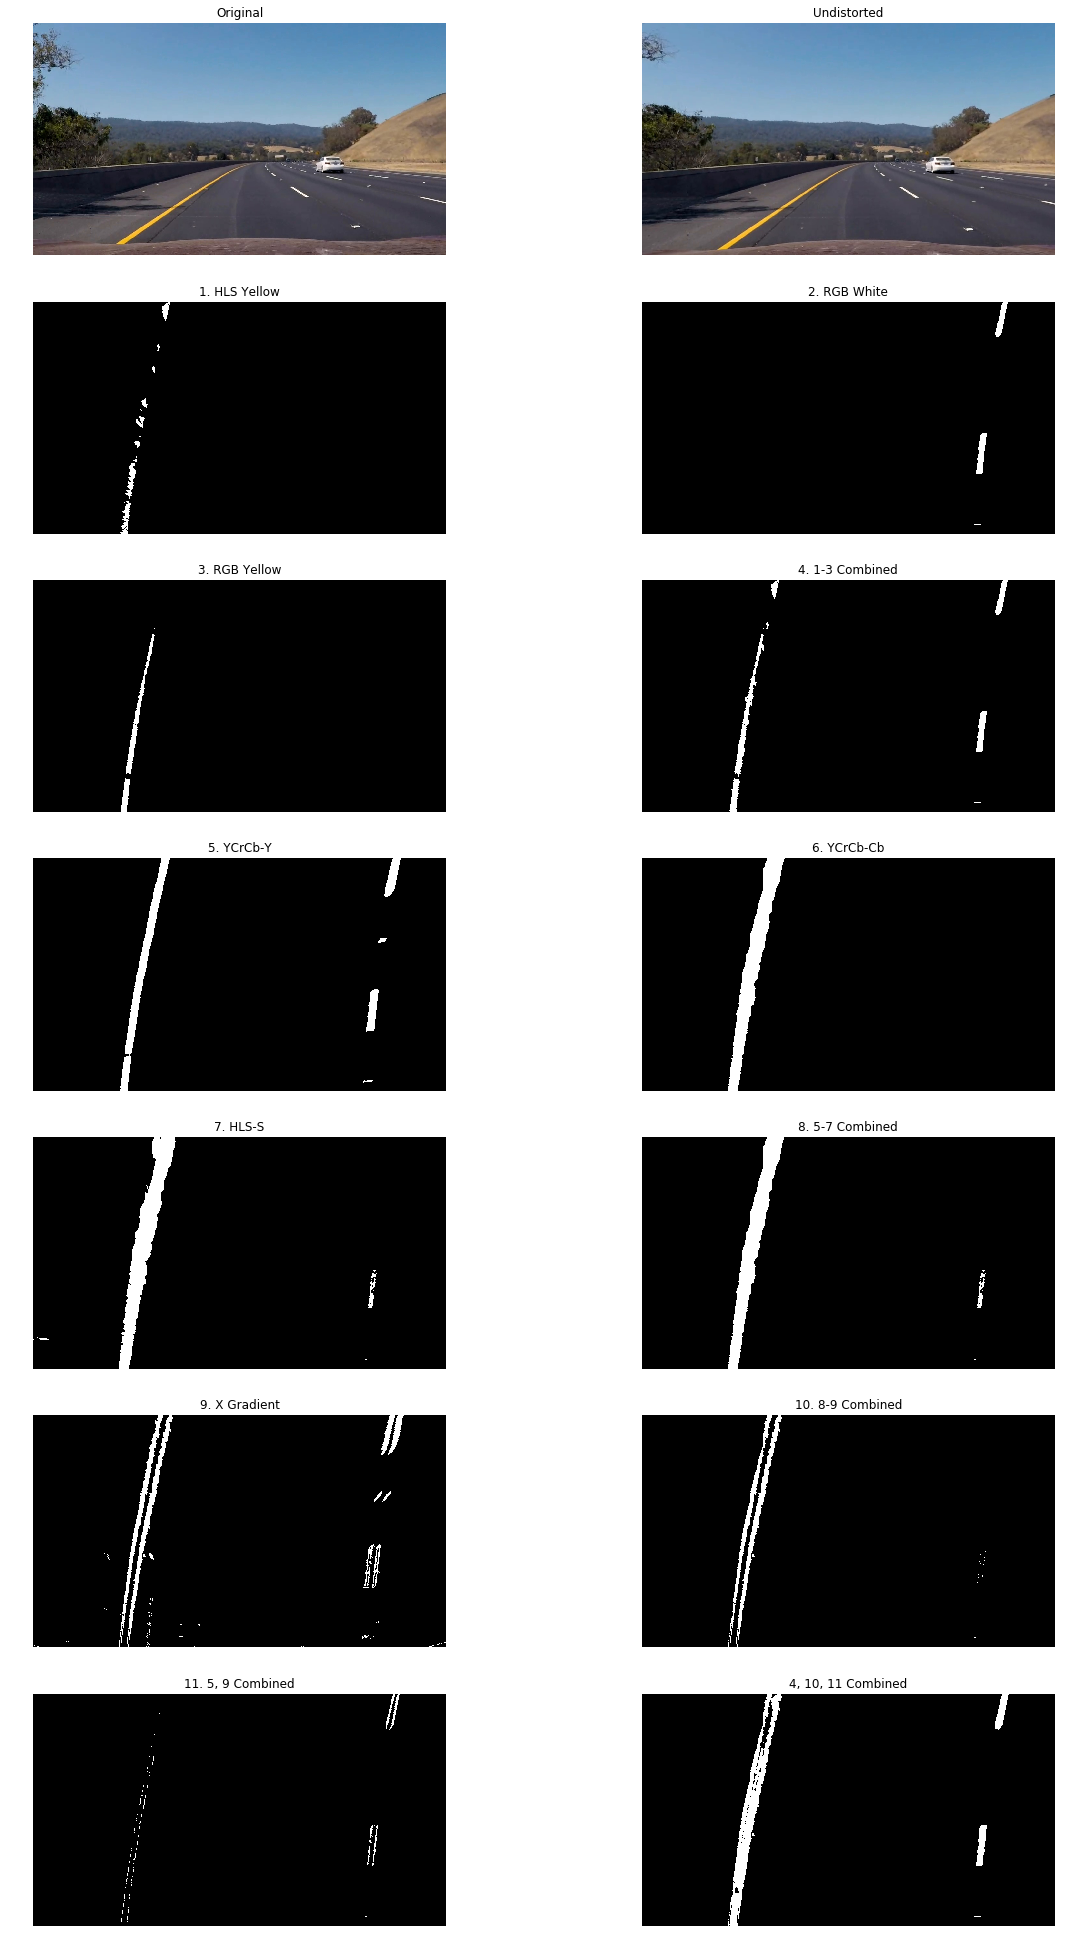

In [8]:
################################
### Visualize pipeline on images
################################

images = glob.glob('./project_video_images/project_video_img*.jpg')
images = images[0:1]
run_pipeline_on_images(images)

In [4]:
def run_pipeline_on_video(input_video, output_video):
    clip = VideoFileClip(input_video)
    ld = Lane_Detector()
    video_clip = clip.fl_image(ld.process_img)
    video_clip.write_videofile(output_video, audio=False)
     

In [6]:
################################
### Run pipeline on videos
################################

#video = 'project_video'
#video = 'challenge_video'
video = 'harder_challenge_video'
run_pipeline_on_video('./project_videos/{}.mp4'.format(video), './processed_videos/{}.mp4'.format(video))

[MoviePy] >>>> Building video ./processed_videos/harder_challenge_video.mp4
[MoviePy] Writing video ./processed_videos/harder_challenge_video.mp4


100%|█████████▉| 1199/1200 [07:45<00:00,  2.94it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./processed_videos/harder_challenge_video.mp4 

